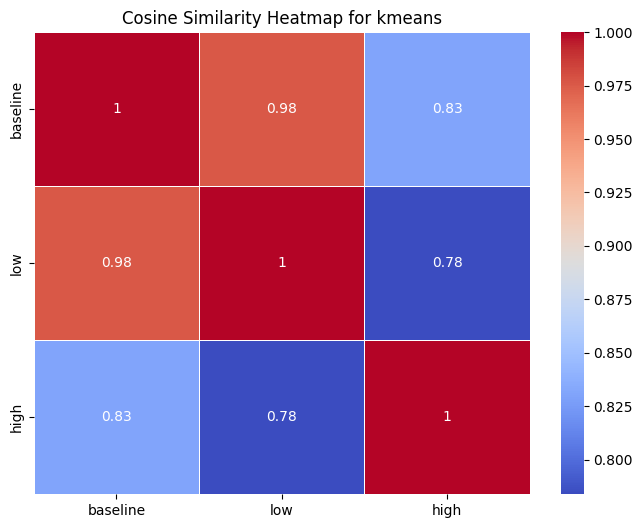

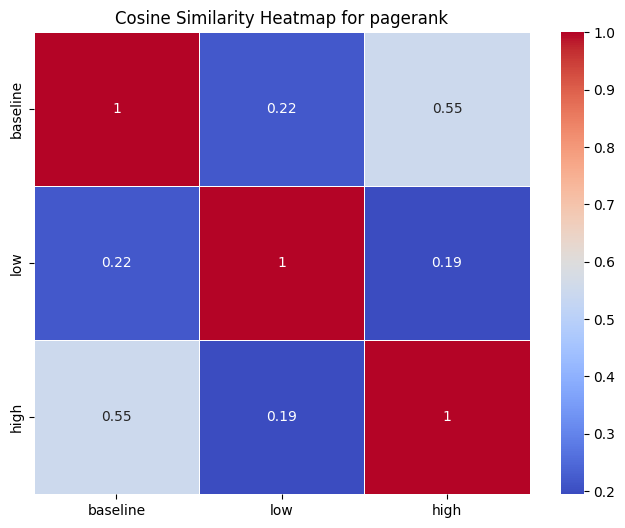

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the cosine similarity function
def cosine_similarity(hist1, hist2):
    hist1 = np.array(hist1)
    hist2 = np.array(hist2)
    dot_product = np.dot(hist1, hist2)
    norm_hist1 = np.linalg.norm(hist1)
    norm_hist2 = np.linalg.norm(hist2)
    similarity = dot_product / (norm_hist1 * norm_hist2)
    return similarity

# Define the directories and metrics
folders = ['baseline', 'low', 'high']
output_base_dir = os.path.join(os.path.dirname(os.getcwd()), 'median')

metrics = {
    'cpu_usage_report_combined_median.csv': '%cpu_utilization',
    'memory_usage_report_combined_median.csv': '%memused',
}

# Function to create histogram and get the last timestamp from file for a specific application
def create_histogram_and_last_timestamp(folder, application):
    hist = []
    last_timestamp = None
    for report, metric in metrics.items():
        file_path = os.path.join(output_base_dir, folder, report)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=';')
            df_app = df[df['application'] == application]
            if not df_app.empty:
                hist.extend(df_app[metric].values)
                last_timestamp = df_app['timeline'].max()
            else:
                print(f"No data for application {application} in {file_path}.")
        else:
            print(f"File {file_path} does not exist.")
    return hist, last_timestamp

# Define the applications of interest
applications_of_interest = ['kmeans', 'pagerank']

# Dictionary to store histograms and last timestamps for each folder
histograms = {folder: {} for folder in folders}
last_timestamps = {folder: {} for folder in folders}

# Create histograms and get last timestamps for each application in each folder
for folder in folders:
    for app in applications_of_interest:
        hist, last_timestamp = create_histogram_and_last_timestamp(folder, app)
        if hist:
            histograms[folder][app] = hist
        if last_timestamp:
            last_timestamps[folder][app] = last_timestamp

# Function to calculate similarity matrix for a specific application
def calculate_similarity_matrix(app):
    similarity_matrix = pd.DataFrame(index=folders, columns=folders)
    for folder1 in folders:
        for folder2 in folders:
            if app in histograms[folder1] and app in histograms[folder2]:
                hist1, hist2 = histograms[folder1][app], histograms[folder2][app]
                # Pad histograms to the same length
                max_len = max(len(hist1), len(hist2))
                if len(hist1) < max_len:
                    hist1 = np.pad(hist1, (0, max_len - len(hist1)), 'constant')
                if len(hist2) < max_len:
                    hist2 = np.pad(hist2, (0, max_len - len(hist2)), 'constant')
                similarity = cosine_similarity(hist1, hist2)
                similarity_matrix.loc[folder1, folder2] = similarity
    similarity_matrix = similarity_matrix.astype(float)
    return similarity_matrix

# Calculate similarity matrices for each application
similarity_matrices = {app: calculate_similarity_matrix(app) for app in applications_of_interest}

# Combine all similarity matrices into a single DataFrame
combined_similarity_df = pd.concat({app: similarity_matrices[app] for app in applications_of_interest}, axis=1)

# Plot the heatmaps
for app in applications_of_interest:
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrices[app], annot=True, cmap='coolwarm', linewidths=.5)
    plt.title(f'Cosine Similarity Heatmap for {app}')
    plt.show()

In [4]:
# Create a LaTeX table with time differences
latex_table = r"""
\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
\textbf{Application} & \textbf{Default Config} & \textbf{Modified Config} & \textbf{Similarity Score} & \textbf{Time Difference (s)} \\ \hline
"""

# Add data to the LaTeX table, filtering for Default Config "baseline nodes"
for app in applications_of_interest:
    for folder2 in folders:
        if folder2 != 'baseline':
            similarity_score = similarity_matrices[app].loc['baseline', folder2]
            default_config = "baseline"
            modified_param = f"{folder2} config"
            baseline_last_timestamp = last_timestamps['baseline'].get(app, 0)
            folder_last_timestamp = last_timestamps[folder2].get(app, 0)
            time_diff = folder_last_timestamp - baseline_last_timestamp
            latex_table += f"{app.capitalize()} & {default_config} & {modified_param} & {similarity_score:.2f} & {time_diff:.2f} \\\\ \\hline\n"

latex_table += r"""
\end{tabular}
\caption{Impact of Workload Parameters on Similarity and Time Differences}
\label{tab:performance-similarity}
\end{table}
"""

# Output the LaTeX table to the terminal
print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
\textbf{Application} & \textbf{Default Config} & \textbf{Modified Hardware} & \textbf{Similarity Score} \\ \hline
Kmeans & baseline & low config & 0.98 \\ \hline
Kmeans & baseline & high config & 0.83 \\ \hline
Pagerank & baseline & low config & 0.22 \\ \hline
Pagerank & baseline & high config & 0.55 \\ \hline

\end{tabular}
\caption{Impact of Number of Nodes on Similarity}
\label{tab:performance-similarity}
\end{table}

